# Initialisation

In [1]:
!pip3 install pickle5
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 14.5 MB/s 


In [2]:
from typing import Tuple
import pickle

import torch.nn as nn
import torch

from torch.utils.data import Subset

from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Training Model

In [3]:
def conv_output_shape(h_w, kernel_size, stride=1, pad=0, dilation=1):
    """
    Utility function for computing output of convolutions
    takes a tuple of (d,h,w) and returns a tuple of (d,h,w)
    """

    if type(h_w) is not tuple:
        h_w = (h_w, h_w, h_w)

    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)

    if type(stride) is not tuple:
        stride = (stride, stride)

    if type(pad) is not tuple:
        pad = (pad, pad)

    h = (h_w[0] + (2 * pad[0]) - (dilation * (kernel_size[0] - 1)) - 1) // stride[0] + 1
    w = (h_w[1] + (2 * pad[1]) - (dilation * (kernel_size[1] - 1)) - 1) // stride[1] + 1

    return h, w


class GRUNet(nn.Module):
    """
    The input is expected to be a 5d tensor of dims [batch_size, time_steps, height, width, n_features]
    representing a height*width region for a certain time_steps period. The region would contain n_features of
    water_velocity, etc. to predict the final output. The final output will be 1 number representing the amount of
    microplastics pieces/m^3.
    """

    def __init__(self, input_dims: Tuple[int], hidden_size: int, output_dim=1, n_layers=1, drop_prob=0):
        super(GRUNet, self).__init__()

        self.batch_size, self.time_steps, self.height, self.width, self.n_features = input_dims

        # hidden size refers to the dimensions of the GRUs hidden state
        self.hidden_size = hidden_size
        # should be 1, as we are predicting only total microplastic concentration in that height*width region
        self.output_dim = output_dim
        # number of stacked GRUs (default 1)
        self.n_layers = n_layers

        # 1*3*3 kernel makes it independent of the time_steps dimension, but n_features being the channel makes sure the
        # convolutions depend on the value of the features of the surrounding pixels
        self.feature_kernel = (1, 3, 3)

        # series of convolutions to reduce dimensionality of height*width*n_features to height*width*1
        # Quite sure ts0 = time_steps as number of time steps should not be changed throughout the convolutions
        # [batch_size, n_features, time_steps, height, width] -> [batch_size, n_features, ts0, h0, w0]
        self.conv0 = nn.Conv3d(self.n_features, self.n_features, self.feature_kernel)
        h0, w0 = conv_output_shape((self.height, self.width), (3, 3))
        # TODO: Add more conv layers
        self.conv1 = nn.Conv3d(self.n_features, self.n_features, self.feature_kernel)
        h1, w1 = conv_output_shape((h0, w0), (3, 3))
        # normalize after convolutions
        self.norm = nn.BatchNorm3d(self.n_features)

        # this final conv layer will learn to compress n_features into 1 number, essentially a 1*1*1*n_features kernel
        # -> [batch_size, 1, ts0, h0, w0]
        self.feature_conv = nn.Conv3d(self.n_features, 1, (1,1,1))
        # squeeze out the 1 dim.
        # -> [batch_size, ts0, h0*w0] flattened final feature map of last 2 dims
        self.flatten = nn.Flatten(-2,-1)

        # input size of GRU will be the flattened feature map size = h0 * w0
        self.gru = nn.GRU(h1*w1, self.hidden_size, self.n_layers, batch_first=True, dropout=drop_prob)
        self.fc0 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.fc1 = nn.Linear(self.hidden_size//2, self.output_dim)

        self.relu = nn.ReLU()

    def forward(self, x, h):
        # permute as conv3d accepts inputs of [batch_size, channels/n_features, D/time_steps, H, W]
        x = torch.permute(x, (0, 4, 1, 2, 3))
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.norm(x)
        x = self.feature_conv(x)
        x = torch.permute(x, (0, 2, 3, 4, 1))
        # remove the 1 dimensional n_features channel. new shape [batch_size, time_steps, height, width]
        x = torch.squeeze(x)
        # flatten the height x width channel into a final feature map. -> [batch_size, time_steps, height * width]
        x = self.flatten(x)

        out, h = self.gru(x, h)
        out = self.fc0(self.relu(out[:, -1]))
        out = self.fc1(self.relu(out))
        out = torch.squeeze(out)

        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.gru.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device)
        return hidden

    
class CustomImageDataset(Dataset):
    def __init__(self, max_shape=(11,11), data_file=r"data/train_data.pickle"):
        with open(data_file, 'rb') as handle:
            # train_files holds a list of [label, time_series] pairs
            # where each label themselves are a list of densities for each time frame.
            train_data = pickle.load(handle)

        # the different time series data are all of different shapes. We have to pad them on the fly.
        self.labels, self.images = zip(*train_data)
        self.height, self.width = max_shape

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # calculate margins for paddings
        top = int(np.floor((self.height - image.shape[1])/2.0))
        bottom = int(np.ceil((self.height - image.shape[1])/2.0))
        left = int(np.floor((self.width - image.shape[2])/2.0))
        right = int(np.ceil((self.width - image.shape[2])/2.0))
        
        # pad the image -> [don't pad time, pad height, pad width, don't pad channels]
        image = np.pad(image, [(0, 0), (top, bottom), (left, right), (0, 0)])
        return image, label


def training_loop(epochs: int, learning_rate: float, data_file=r"data/train_data.pickle"):
    # Setting common hyperparameters, adjust later depending on input
    hidden_dim = 128
    batch_size = 128
    time_steps = 7
    
    # from the better_get_data.ipynb notebook we know the max is 11 x 11 images
    height = 11
    width = 11
    n_features = 2
    
    # setup train data
    dataset = CustomImageDataset(max_shape=(height, width), data_file=data_file)

    train_size = int(0.85 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    input_dim = (batch_size, time_steps, height, width, n_features)

    output_dim = 1
    n_layers = 1
    drop_prob = 0

    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers, drop_prob)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    print(f"Starting Training of model")
    epoch_times = []
    epoch_losses = []
    save_epoch_interval = 500

    for i in range(epochs):
        start_time = time.time()
        avg_loss = 0
        counter = 0

        for x, label in train_loader:
            h = model.init_hidden(batch_size).detach()
            model.zero_grad()
            counter += 1

            output, h = model.forward(x.to(device).float(), h)
            loss = criterion(output, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        current_time = time.time()
        print(f"Epoch {i+1}/{epochs} Done, Total Loss: {avg_loss/len(train_loader)}")
        epoch_losses.append(avg_loss/len(train_loader))
        print(f"Total Time Elapsed: {current_time-start_time} seconds")
        epoch_times.append(current_time-start_time)

        if (i % save_epoch_interval == 0 and i != 0):
          torch.save(model.state_dict(), f"GRU_epoch:{i}_loss:{avg_loss/len(train_loader):.3f}.pt")


    print(f"Total Training Time: {sum(epoch_times)} seconds")

    print("-------------EVALUATING---------------")
    print('[prediction, target]')
    for x, label in test_loader:
      with torch.no_grad():
        h = model.init_hidden(batch_size)
        output, h = model.forward(x.to(device).float(), h)
        print(torch.stack([output.to('cpu'), label], axis=1))

    return model, epoch_losses


model, epoch_losses = training_loop(2000, 1e-4, 'train_data.pickle')
plt.plot(epoch_losses)

Starting Training of model
Epoch 1/2000 Done, Total Loss: 30.28877080914612
Total Time Elapsed: 6.58827543258667 seconds
Epoch 2/2000 Done, Total Loss: 30.152173485670048
Total Time Elapsed: 1.0105547904968262 seconds
Epoch 3/2000 Done, Total Loss: 30.10734748335208
Total Time Elapsed: 0.9791436195373535 seconds
Epoch 4/2000 Done, Total Loss: 30.104331278699938
Total Time Elapsed: 0.9941096305847168 seconds
Epoch 5/2000 Done, Total Loss: 30.111745155084943
Total Time Elapsed: 1.022986888885498 seconds
Epoch 6/2000 Done, Total Loss: 30.1035073624324
Total Time Elapsed: 1.01405668258667 seconds
Epoch 7/2000 Done, Total Loss: 30.10400667256218
Total Time Elapsed: 1.0037105083465576 seconds
Epoch 8/2000 Done, Total Loss: 30.100730524477314
Total Time Elapsed: 1.0034499168395996 seconds
Epoch 9/2000 Done, Total Loss: 30.100654390908904
Total Time Elapsed: 1.0033700466156006 seconds
Epoch 10/2000 Done, Total Loss: 30.0985786738032
Total Time Elapsed: 0.9995467662811279 seconds
Epoch 11/2000 

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), "gru_model.pt")

# Evaluating Model

In [4]:
def conv_output_shape(h_w, kernel_size, stride=1, pad=0, dilation=1):
    """
    Utility function for computing output of convolutions
    takes a tuple of (d,h,w) and returns a tuple of (d,h,w)
    """

    if type(h_w) is not tuple:
        h_w = (h_w, h_w, h_w)

    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)

    if type(stride) is not tuple:
        stride = (stride, stride)

    if type(pad) is not tuple:
        pad = (pad, pad)

    h = (h_w[0] + (2 * pad[0]) - (dilation * (kernel_size[0] - 1)) - 1) // stride[0] + 1
    w = (h_w[1] + (2 * pad[1]) - (dilation * (kernel_size[1] - 1)) - 1) // stride[1] + 1

    return h, w

class CustomImageDataset(Dataset):
    def __init__(self, max_shape=(11,11), data_file=r"data/train_data.pickle"):
        with open(data_file, 'rb') as handle:
            # train_files holds a list of [label, time_series] pairs
            # where each label themselves are a list of densities for each time frame.
            train_data = pickle.load(handle)

        # the different time series data are all of different shapes. We have to pad them on the fly.
        self.labels, self.images = zip(*train_data)
        self.height, self.width = max_shape

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # calculate margins for paddings
        top = int(np.floor((self.height - image.shape[1])/2.0))
        bottom = int(np.ceil((self.height - image.shape[1])/2.0))
        left = int(np.floor((self.width - image.shape[2])/2.0))
        right = int(np.ceil((self.width - image.shape[2])/2.0))
        
        # pad the image -> [don't pad time, pad height, pad width, don't pad channels]
        image = np.pad(image, [(0, 0), (top, bottom), (left, right), (0, 0)])
        return image, label

class GRUNet(nn.Module):
    """
    The input is expected to be a 5d tensor of dims [batch_size, time_steps, height, width, n_features]
    representing a height*width region for a certain time_steps period. The region would contain n_features of
    water_velocity, etc. to predict the final output. The final output will be 1 number representing the amount of
    microplastics pieces/m^3.
    """

    def __init__(self, input_dims: Tuple[int], hidden_size: int, output_dim=1, n_layers=1, drop_prob=0):
        super(GRUNet, self).__init__()

        self.batch_size, self.time_steps, self.height, self.width, self.n_features = input_dims

        # hidden size refers to the dimensions of the GRUs hidden state
        self.hidden_size = hidden_size
        # should be 1, as we are predicting only total microplastic concentration in that height*width region
        self.output_dim = output_dim
        # number of stacked GRUs (default 1)
        self.n_layers = n_layers

        # 1*3*3 kernel makes it independent of the time_steps dimension, but n_features being the channel makes sure the
        # convolutions depend on the value of the features of the surrounding pixels
        self.feature_kernel = (1, 3, 3)

        # series of convolutions to reduce dimensionality of height*width*n_features to height*width*1
        # Quite sure ts0 = time_steps as number of time steps should not be changed throughout the convolutions
        # [batch_size, n_features, time_steps, height, width] -> [batch_size, n_features, ts0, h0, w0]
        self.conv0 = nn.Conv3d(self.n_features, self.n_features, self.feature_kernel)
        h0, w0 = conv_output_shape((self.height, self.width), (3, 3))
        # TODO: Add more conv layers
        self.conv1 = nn.Conv3d(self.n_features, self.n_features, self.feature_kernel)
        h1, w1 = conv_output_shape((h0, w0), (3, 3))
        # normalize after convolutions
        self.norm = nn.BatchNorm3d(self.n_features)

        # this final conv layer will learn to compress n_features into 1 number, essentially a 1*1*1*n_features kernel
        # -> [batch_size, 1, ts0, h0, w0]
        self.feature_conv = nn.Conv3d(self.n_features, 1, (1,1,1))
        # squeeze out the 1 dim.
        # -> [batch_size, ts0, h0*w0] flattened final feature map of last 2 dims
        self.flatten = nn.Flatten(-2,-1)

        # input size of GRU will be the flattened feature map size = h0 * w0
        self.gru = nn.GRU(h1*w1, self.hidden_size, self.n_layers, batch_first=True, dropout=drop_prob)
        self.fc0 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.fc1 = nn.Linear(self.hidden_size//2, self.output_dim)

        self.relu = nn.ReLU()

    def forward(self, x, h):
        # permute as conv3d accepts inputs of [batch_size, channels/n_features, D/time_steps, H, W]
        x = torch.permute(x, (0, 4, 1, 2, 3))
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.norm(x)
        x = self.feature_conv(x)
        x = torch.permute(x, (0, 2, 3, 4, 1))
        # remove the 1 dimensional n_features channel. new shape [batch_size, time_steps, height, width]
        x = torch.squeeze(x)
        # flatten the height x width channel into a final feature map. -> [batch_size, time_steps, height * width]
        x = self.flatten(x)

        out, h = self.gru(x, h)
        out = self.fc0(self.relu(out[:, -1]))
        out = self.fc1(self.relu(out))
        out = torch.squeeze(out)

        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.gru.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device)
        return hidden


def init_model_eval(model_path):
    # copied the same parameters as the model was trained with.
    hidden_dim = 128
    batch_size = 128
    time_steps = 7
    height = 11
    width = 11
    n_features = 2
    output_dim = 1
    n_layers = 1
    drop_prob = 0
    input_dim = (batch_size, time_steps, height, width, n_features)

    # load model in eval mode
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers, drop_prob)
    model.load_state_dict(torch.load(model_path))
    model.eval().to(device)

    return model

model = init_model_eval(r'model_checkpoints/GRU_epoch_1500_loss_3.401.pt')

# setup test evaluation splits

dataset = CustomImageDataset(max_shape=(11, 11), data_file='data/train_data.pickle')

train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=True)

mse = nn.MSELoss()
batch_size = 128
avg_loss = 0
counter = 0
logs = []

with torch.inference_mode():
    for x, label in train_loader:
        h = model.init_hidden(batch_size)
        counter += 1

        output, h = model.forward(x.to(device).float(), h)
        loss = mse(output, label.to(device).float())
        avg_loss += loss.item()

        logs.append(torch.stack([label, output.to(label.device)], dim=0))

print(f"Test evaluation complete, MSE: {avg_loss/len(train_loader)}")

Test evaluation complete, MSE: 3.29474286634033


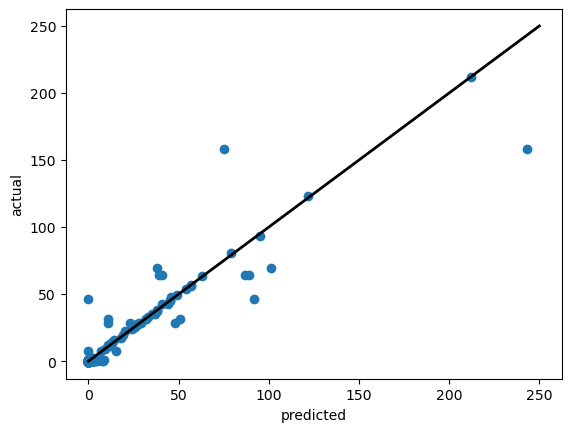

In [6]:
datapoints = torch.cat(logs, dim=1)

plt.scatter(datapoints[0], datapoints[1])
plt.plot([0, 250], [0, 250], 'k-', lw=2)
plt.ylabel('actual')
plt.xlabel('predicted')
plt.show()

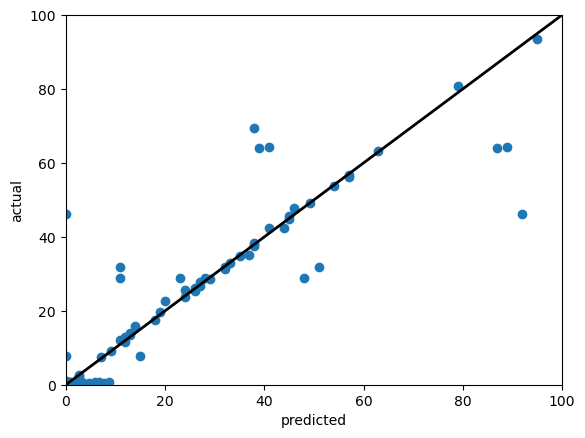

In [10]:
plt.scatter(datapoints[0], datapoints[1])
plt.plot([0, 250], [0, 250], 'k-', lw=2)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.ylabel('actual')
plt.xlabel('predicted')
plt.show()

We can see that the model has a few 0 predictions because it fails to pick up on the extremely small microplastic concentrations. This suggests that while the model can identify the patterns for most values, especially for larger concentrations, it fails when the microplastics concentration is rather small, and this is an area for improvement.